# 05. Lenses and analysing lensing actions

submitted by [substancia](https://github.com/substancia), adapted by [flaport](https://github.com/flaport)

## Imports

In [1]:
import os
import fdtd
import numpy as np
import matplotlib.pyplot as plt

## Grid

In [2]:
grid = fdtd.Grid(shape=(260, 15.5e-6, 1), grid_spacing=77.5e-9)
# x boundaries
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")
# y boundaries
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")
simfolder = grid.save_simulation("Lenses")  # initializing environment to save simulation data
print(simfolder)

/home/tb/repos/magisim/src/tests/fdtd_output/fdtd_output_2023-11-10-10-25-58 (Lenses)


## Objects

defining a biconvex lens

In [3]:
x, y = np.arange(-200, 200, 1), np.arange(190, 200, 1)
X, Y = np.meshgrid(x, y)
lens_mask = X ** 2 + Y ** 2 <= 40000
for j, col in enumerate(lens_mask.T):
    for i, val in enumerate(np.flip(col)):
        if val:
            grid[30 + i : 50 - i, j - 100 : j - 99, 0] = fdtd.Object(permittivity=1.5 ** 2, name=str(i) + "," + str(j))
            break

## Source
using a continuous source (not a pulse)

In [4]:
grid[15, 50:150, 0] = fdtd.LineSource(period=1550e-9 / (3e8), name="source")

## Detectors
using a BlockDetector

In [5]:
grid[80:200, 80:120, 0] = fdtd.BlockDetector(name="detector")

Saving grid geometry for future reference

In [6]:
with open(os.path.join(simfolder, "grid.txt"), "w") as f:
    f.write(str(grid))
    wavelength = 3e8/grid.source.frequency
    wavelengthUnits = wavelength/grid.grid_spacing
    GD = np.array([grid.x, grid.y, grid.z])
    gridRange = [np.arange(x/grid.grid_spacing) for x in GD]
    objectRange = np.array([[gridRange[0][x.x], gridRange[1][x.y], gridRange[2][x.z]] for x in grid.objects], dtype=object).T
    f.write("\n\nGrid details (in wavelength scale):")
    f.write("\n\tGrid dimensions: ")
    f.write(str(GD/wavelength))
    f.write("\n\tSource dimensions: ")
    f.write(str(np.array([grid.source.x[-1] - grid.source.x[0] + 1, grid.source.y[-1] - grid.source.y[0] + 1, grid.source.z[-1] - grid.source.z[0] + 1])/wavelengthUnits))
    f.write("\n\tObject dimensions: ")
    f.write(str([(max(map(max, x)) - min(map(min, x)) + 1)/wavelengthUnits for x in objectRange]))

## Simulation

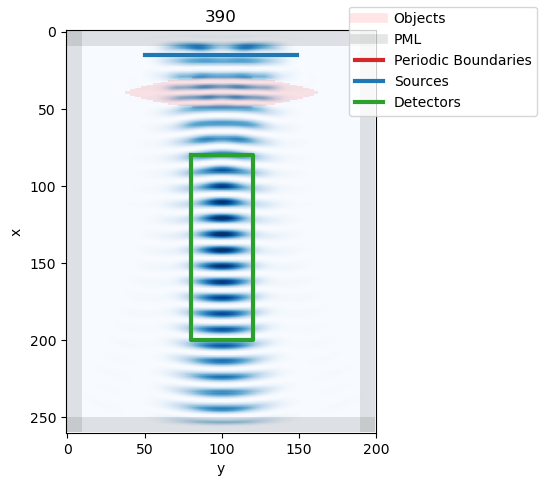

In [7]:
from IPython.display import clear_output # only necessary in jupyter notebooks
for i in range(400):
    grid.step()  # running simulation 1 timestep a time and animating
    if i % 10 == 0:
        # saving frames during visualization
        grid.visualize(z=0, animate=True, index=i, save=True, folder=simfolder)
        plt.title(f"{i:3.0f}")
        clear_output(wait=True) # only necessary in jupyter notebooks

grid.save_data()  # saving detector readings

We can generate a video with ffmpeg:

In [8]:
try:
    video_path = grid.generate_video(delete_frames=False)  # rendering video from saved frames
except:
    video_path = ""
    print("ffmpeg not installed?")

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


In [11]:
if video_path:
    from IPython.display import Video
    display(Video(video_path, embed=True))

## Analyse
analysing data stored by above simulation by plotting a 2D decibel map

100%|██████████| 121/121 [00:00<00:00, 156.20it/s]


Peak at: [[[45, 20]]]


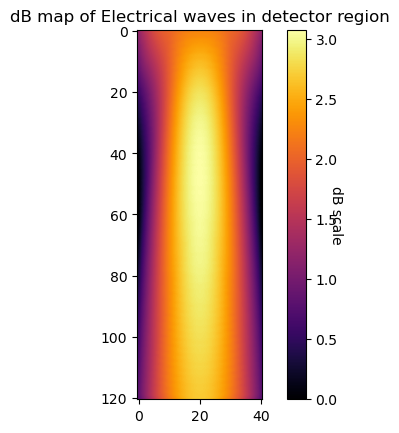

In [10]:
df = np.load(os.path.join(simfolder, "detector_readings.npz"))
fdtd.dB_map_2D(df["detector (E)"])